In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(18641, 21)
(18641, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -1] == 1)[0]
X_footsteps_accelerations_absolute_FR_swinging = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_FR_swinging = Y_footsteps_accelerations_absolute[idxs]

## Predict FR foot -> x

In [8]:
X_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.02925825,  0.01290209,
        0.0145091 ,  0.01718734,  0.24676163,  0.13144901, -0.38242608,
        0.23224038, -0.12821306, -0.38609892, -0.26756632,  0.12496905,
       -0.39002576, -0.25319165, -0.12552589, -0.38698047,  0.        ,
        1.        ])

In [9]:
Y_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 3.76987239e-02, -2.84286750e-03,  3.80168041e-02, -5.36085387e-05])

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [11]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 0:1], # current reference velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # actual velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 7:9], # FL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 10:12], # FR position
               X_footsteps_accelerations_absolute_FR_swinging[:, 13:15], # RL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 16:18])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9901693325427208
RMSE:  0.02214762206096049
The lowest error is:  1.9439688666120225e-05
The highest error is:  0.08631604710599744
The avg. error is:  0.01648061761492619


In [12]:
model_fr_relative_swinging_x.coef_

array([[ 0.0772539 ,  0.66546657, -0.48114255, -0.45338576, -1.64850384,
         0.64718163,  0.61471063, -0.018211  , -1.41160375, -1.48807261]])

In [13]:
model_fr_relative_swinging_x.intercept_

array([0.26133981])

Text(0, 0.5, 'Predictions')

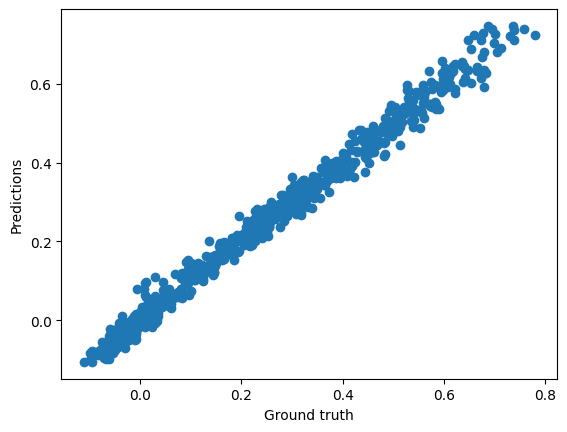

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'{X_test[idx, 0]}->{X_test[idx, 1]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [16]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 0:1], # current reference velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # actual velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 7:9], # FL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 10:12], # FR position
               X_footsteps_accelerations_absolute_FR_swinging[:, 13:15], # RL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 16:18])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.9027851548230139
RMSE:  0.009441600092356735
The lowest error is:  2.4743997782848345e-06
The highest error is:  0.03160219941813718
The avg. error is:  0.0071431844762018136


In [17]:
model_fr_relative_swinging_y.coef_

array([[ 0.0153408 , -0.10082556, -0.54858947,  0.331158  , -0.48198103,
        -1.66376876,  0.37445464, -0.24880407,  1.04370394,  0.76600611]])

In [18]:
model_fr_relative_swinging_y.intercept_

array([0.48440744])

Text(0, 0.5, 'Predictions')

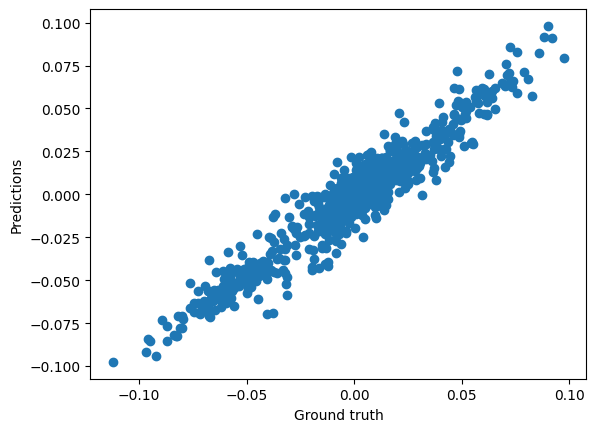

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')